# Metric design for B2C experiments: ARPU, ratio metrics and linearization

This notebook illustrates how to work with B2C metrics using the `metrics` helpers:

- simple summaries of customer-level metrics;
- ratio metrics (e.g. revenue per session);
- linearization of ratio metrics for use in standard t-tests.

We use a simulated B2C scenario with:

- a control group (A) and a treatment group (B),
- heterogeneous user behaviour (different numbers of sessions),
- a small uplift in revenue per session in the treatment group.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

plt.style.use("default")
plt.rcParams["figure.figsize"] = (7, 4)

from tecore.metrics import (
    summarize_metric,
    ratio_metric,
    linearize_ratio,
    make_per_user_arrays,
)

## 1. Simulated B2C scenario

We simulate a simple B2C product with the following assumptions:

- Each user has a random number of **sessions** during the experiment.
- In each session, the user generates some **revenue**.
- The treatment increases **revenue per session** by a small amount (e.g. +5%).

This leads to:

- high variability in total revenue per user (ARPU),
- heterogeneous user behaviour (some users are very active, others barely active).

We will compare:

- naive ARPU comparison (revenue per user),
- a ratio metric: revenue per session,
- linearized values for the ratio metric.

In [3]:
rng = np.random.default_rng(42)

n_users = 5000

# --- Control group (A) ---
# Number of sessions per user (ensure at least 1 session)
sessions_A = rng.poisson(lam=3.0, size=n_users)
sessions_A = np.clip(sessions_A, 1, None)

# Revenue per session: baseline level + noise
revenue_per_session_A = 1.0
noise_A = rng.normal(loc=0.0, scale=0.3, size=n_users * np.max(sessions_A))
noise_A = noise_A.reshape(-1) 

# For simplicity, total revenue per user:
# revenue = revenue_per_session * sessions + small noise per user
revenues_A = revenue_per_session_A * sessions_A + rng.normal(
    loc=0.0, scale=0.5, size=n_users
)
revenues_A = np.clip(revenues_A, 0.0, None)  # no negative revenue

# --- Treatment group (B) ---
sessions_B = rng.poisson(lam=3.0, size=n_users)
sessions_B = np.clip(sessions_B, 1, None)

# Slightly higher revenue per session in the treatment group
revenue_per_session_B = 1.05  # +5%
revenues_B = revenue_per_session_B * sessions_B + rng.normal(
    loc=0.0, scale=0.5, size=n_users
)
revenues_B = np.clip(revenues_B, 0.0, None)

len(sessions_A), len(revenues_A), len(sessions_B), len(revenues_B)

(5000, 5000, 5000, 5000)

In [4]:
print("Basic descriptive stats per user")
print(f"Avg sessions A: {sessions_A.mean():.2f}, B: {sessions_B.mean():.2f}")
print(f"Avg revenue  A: {revenues_A.mean():.2f}, B: {revenues_B.mean():.2f}")
print(f"Uplift in ARPU (B - A): {revenues_B.mean() - revenues_A.mean():.3f}")

Basic descriptive stats per user
Avg sessions A: 3.05, B: 3.04
Avg revenue  A: 3.05, B: 3.18
Uplift in ARPU (B - A): 0.130


## 2. Naive ARPU comparison (revenue per user)

First, we treat **revenue per user** as our main metric (ARPU):

- For each user, we just use the total revenue over the experiment.
- We compare groups A and B using a standard t-test.

This is a very common approach in practice.

In [5]:
# from tecore.metrics import summarize_metric

summary_A = summarize_metric(revenues_A)
summary_B = summarize_metric(revenues_B)

print("ARPU summary")
print(f"Group A: n = {summary_A.n}, mean = {summary_A.mean:.3f}, std = {summary_A.std:.3f}")
print(f"Group B: n = {summary_B.n}, mean = {summary_B.mean:.3f}, std = {summary_B.std:.3f}")

# Two-sample t-test on raw ARPU (Welch's t-test)
t_stat_arpu, p_value_arpu = ttest_ind(revenues_B, revenues_A, equal_var=False)
print()
print("t-test on raw ARPU (B vs A)")
print(f"t-statistic = {t_stat_arpu:.3f}")
print(f"p-value     = {p_value_arpu:.4f}")

ARPU summary
Group A: n = 5000, mean = 3.049, std = 1.749
Group B: n = 5000, mean = 3.179, std = 1.811

t-test on raw ARPU (B vs A)
t-statistic = 3.642
p-value     = 0.0003


## 3. Ratio metric: revenue per session

Total revenue per user mixes two effects:

- how many sessions the user had;
- how much revenue each session produced.

If we are primarily interested in **revenue per session**, a more natural metric is:

$$
R = \frac{\sum_i \text{revenue}_i}{\sum_i \text{sessions}_i}
$$

We will:

- compute the group-level ratio for A and B,
- see how much it differs between the groups.

In [7]:
from tecore.metrics import ratio_metric

ratio_A = ratio_metric(revenues_A, sessions_A)
ratio_B = ratio_metric(revenues_B, sessions_B)

print("Ratio metric: revenue per session")
print(f"Group A: R = {ratio_A.ratio:.3f}")
print(f"Group B: R = {ratio_B.ratio:.3f}")
print(f"Absolute difference (B - A): {ratio_B.ratio - ratio_A.ratio:.3f}")
print(f"Relative uplift: {(ratio_B.ratio / ratio_A.ratio - 1) * 100:.2f}%")

Ratio metric: revenue per session
Group A: R = 0.999
Group B: R = 1.046
Absolute difference (B - A): 0.048
Relative uplift: 4.77%


## 4. Linearization of the ratio metric

Ratio metrics are tricky for classical t-tests:

- the numerator and denominator can be correlated;
- user activity (number of sessions) is highly variable.

A common approach is **linearization**:

1. Choose a baseline ratio \\( R \\) (for example, the ratio in the control group).
2. For each observation \\( (x_i, y_i) \\) compute

$$
z_i = x_i - R \cdot y_i
$$

Under mild assumptions, we can then compare the means of \\( z_i \\) between groups
using standard t-tests, as if this were a non-ratio metric.

Below we:

- use the control-group ratio as \\( R \\),
- compute linearized values for both groups,
- compare t-tests on ARPU vs. linearized ratio.

In [8]:
from tecore.metrics import linearize_ratio

# Use control group's ratio as baseline R
baseline_R = ratio_A.ratio
print(f"Baseline R (control revenue per session): {baseline_R:.3f}")

z_A = linearize_ratio(revenues_A, sessions_A, baseline_ratio=baseline_R)
z_B = linearize_ratio(revenues_B, sessions_B, baseline_ratio=baseline_R)

# Summaries for linearized values
summary_z_A = summarize_metric(z_A)
summary_z_B = summarize_metric(z_B)

print("\nLinearized values summary (z = revenue - R * sessions)")
print(f"Group A: mean = {summary_z_A.mean:.4f}, std = {summary_z_A.std:.4f}")
print(f"Group B: mean = {summary_z_B.mean:.4f}, std = {summary_z_B.std:.4f}")

# t-test on linearized values
t_stat_lin, p_value_lin = ttest_ind(z_B, z_A, equal_var=False)

print("\nt-test on linearized ratio metric (B vs A)")
print(f"t-statistic = {t_stat_lin:.3f}")
print(f"p-value = {p_value_lin:.6f}")

Baseline R (control revenue per session): 0.999

Linearized values summary (z = revenue - R * sessions)
Group A: mean = -0.0000, std = 0.4989
Group B: mean = 0.1447, std = 0.5088

t-test on linearized ratio metric (B vs A)
t-statistic = 14.354
p-value     = 0.000000


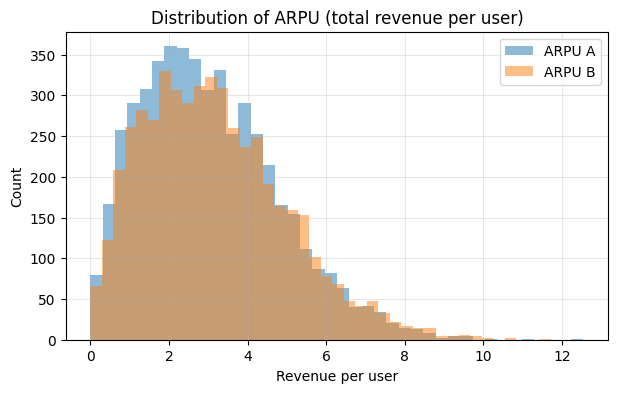

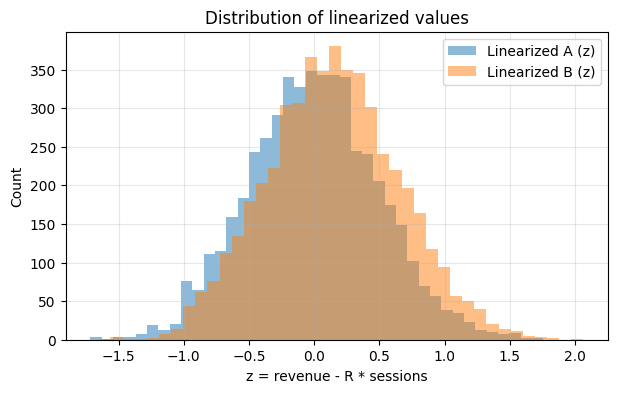

In [9]:
plt.figure()
plt.hist(revenues_A, bins=40, alpha=0.5, label="ARPU A")
plt.hist(revenues_B, bins=40, alpha=0.5, label="ARPU B")
plt.title("Distribution of ARPU (total revenue per user)")
plt.xlabel("Revenue per user")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.hist(z_A, bins=40, alpha=0.5, label="Linearized A (z)")
plt.hist(z_B, bins=40, alpha=0.5, label="Linearized B (z)")
plt.title("Distribution of linearized values")
plt.xlabel("z = revenue - R * sessions")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Takeaways

In this simulated B2C scenario:

- Users have very different levels of activity (number of sessions).
- Total revenue per user (ARPU) is noisy and mixes:
  - how active the user was,
  - how profitable each session was.

We saw that:

- ARPU comparison gives one view of the effect, but with relatively high variance.
- A ratio metric (revenue per session) better isolates the effect we care about.
- Linearization of the ratio metric allows us to:
  - keep the per-user view (each user is one observation),
  - use standard statistical tests (t-tests),
  - often obtain a clearer, more stable signal.

This notebook focuses on **intuition and practical tools**, not on strict
theoretical guarantees. In real experiments, we would also consider:

- segmentation (VIP vs non-VIP users),
- seasonality and time effects,
- combining linearization with sequential testing and other guardrails.